High          Low         Open        Close    Volume  \
Date                                                                       
2019-12-02   336.380005   328.690002   329.399994   334.869995   6074500   
2019-12-03   337.910004   332.190002   332.619995   336.200012   6573700   
2019-12-04   337.859985   332.850006   337.750000   333.029999   5533000   
2019-12-05   334.420013   327.250000   332.829987   330.369995   3724600   
2019-12-06   338.859985   334.769989   335.000000   335.890015   7612400   
...                 ...          ...          ...          ...       ...   
2020-07-24  1465.000000  1366.540039  1416.010010  1417.000000  19396600   
2020-07-27  1547.939941  1413.000000  1435.000000  1539.599976  16048700   
2020-07-28  1564.699951  1474.420044  1504.000000  1476.489990  15808700   
2020-07-29  1534.810059  1487.000000  1501.000000  1499.109985   9426900   
2020-07-30  1513.239990  1471.000000  1488.000000  1487.489990   7600200   

              Adj Close  
Date

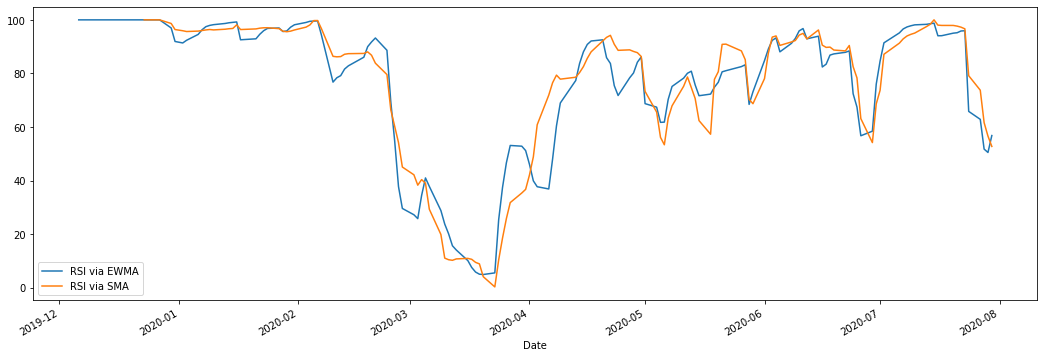

In [65]:

import datetime
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web


# Window length for moving average
mean_lenght = 4
window_length = 12

# Dates
start = '2019-12-01'
end = '2020-07-30'

# Get data
stock = 'TSLA'
data = web.DataReader(stock, 'yahoo', start, end)
print(data)
# Get just the adjusted close
close = data['Adj Close']
volume = data['Volume']

# Get the difference in price from previous step
delta = close.diff()
# Get rid of the first row, which is NaN since it did not have a previous 
# row to calculate the differences
delta = delta[1:] 

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy().rolling(window=mean_lenght).mean(), delta.copy().rolling(window=mean_lenght).mean()
up[up < 0] = 0
down[down > 0] = 0

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

# Calculate the SMA
roll_up2 = up.rolling(window_length).mean()
roll_down2 = down.abs().rolling(window_length).mean()

# Calculate the RSI based on SMA
RS2 = roll_up2 / roll_down2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))


# Compare graphically
plt.figure(figsize=(18, 6))
RSI1.plot()
RSI2.plot()
plt.legend(['RSI via EWMA', 'RSI via SMA'])
plt.show()


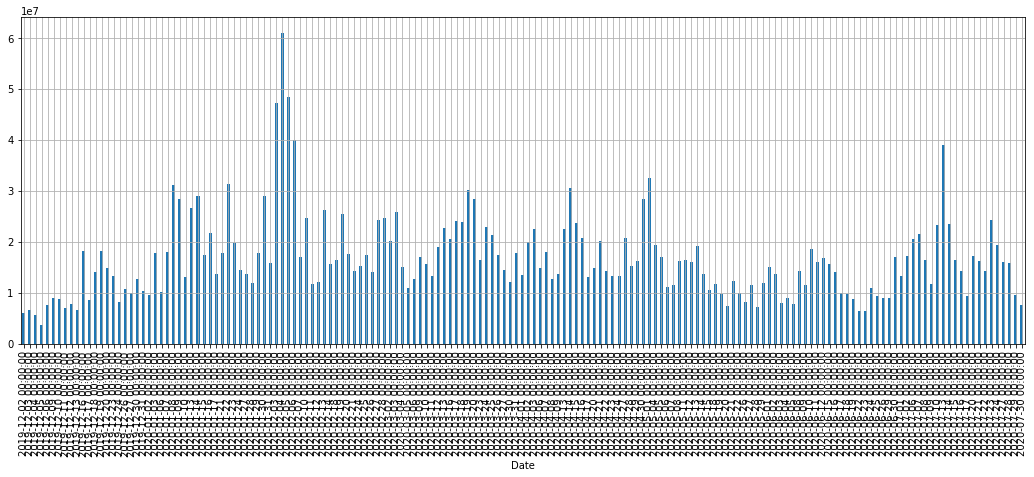

In [66]:
volume.plot.bar(figsize=(18, 6))
plt.grid()
plt.show()

In [67]:
buy_sell_signal = RSI1.rolling(window=2).mean()
low_threshold = 20
high_threshold = 80
buy_sell_signal[buy_sell_signal > 60] = 100
buy_sell_signal[buy_sell_signal < 30] = 0
#buy_sell_signal = np.where(buy_sell_signal != 100, 50)


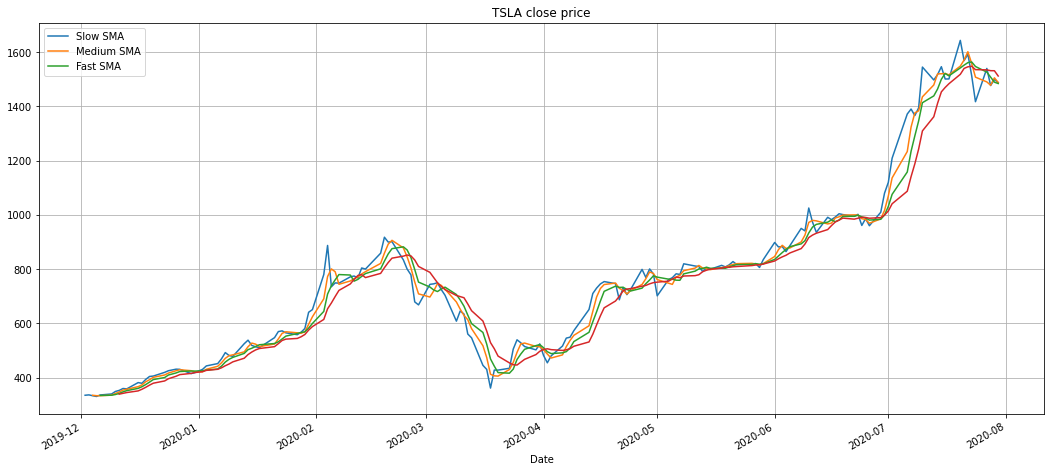

In [68]:
fast_window_length = 3
medium_window_length = 5
slow_window_length = 8

#fast_ema = close.ewm(span=fast_window_length, adjust=False).mean()
#medium_ema = close.ewm(span=medium_window_length, adjust=False).mean()
#slow_ema = close.ewm(span=slow_window_length, adjust=False).mean()

fast_ema = close.rolling(window=fast_window_length).mean()
medium_ema = close.rolling(window=medium_window_length).mean()
slow_ema = close.rolling(window=slow_window_length).mean()

import datetime
import pandas_datareader.data as web


# Window length for moving average
window_length = 14

# Dates
close.plot(title=stock + " close price", figsize=(18,8))
fast_ema.plot()
medium_ema.plot()
slow_ema.plot()
plt.legend(['Slow SMA', 'Medium SMA', 'Fast SMA'])
plt.grid()
plt.show()

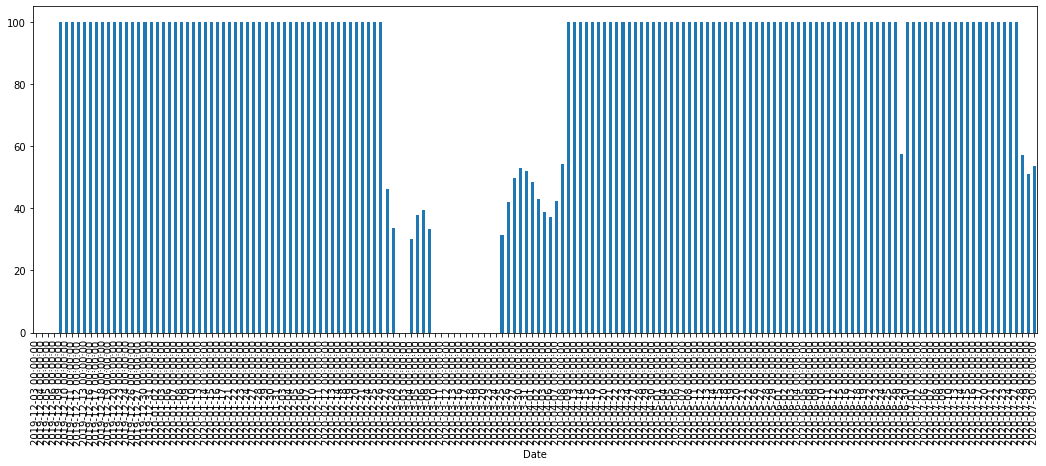

In [69]:
buy_sell_signal.plot.bar(figsize=(18, 6))
plt.show()


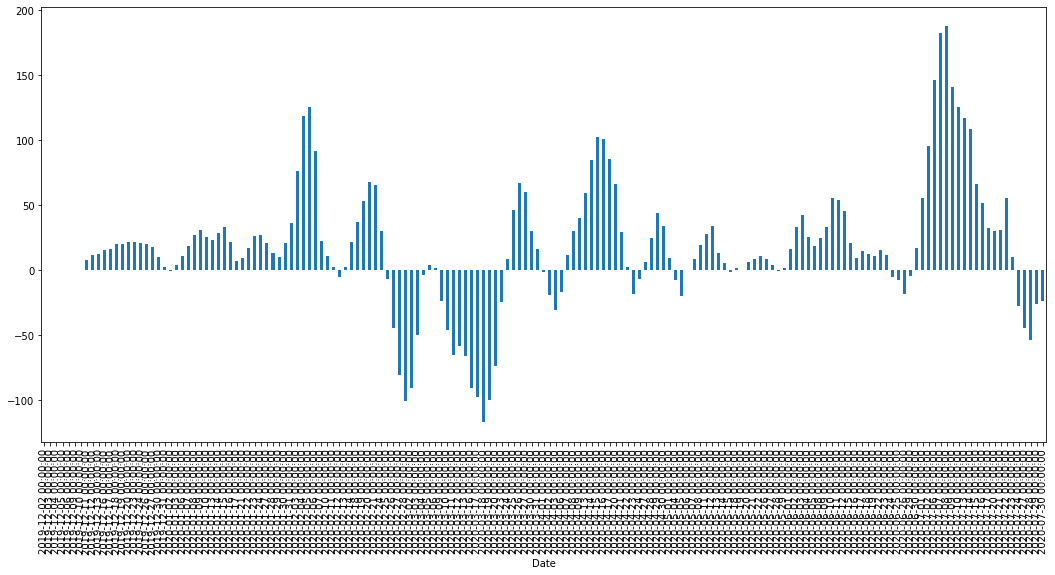

In [70]:
macd = fast_ema - slow_ema
macd.plot.bar(figsize=(18,8))
plt.show()

Entering overbought zone at 4
Exiting overbought zone at 58
Entering oversold zone at 60
Exiting oversold zone at 62
Entering oversold zone at 66
Exiting oversold zone at 77
Entering overbought zone at 88
Exiting overbought zone at 143
Entering overbought zone at 144
Exiting overbought zone at 163


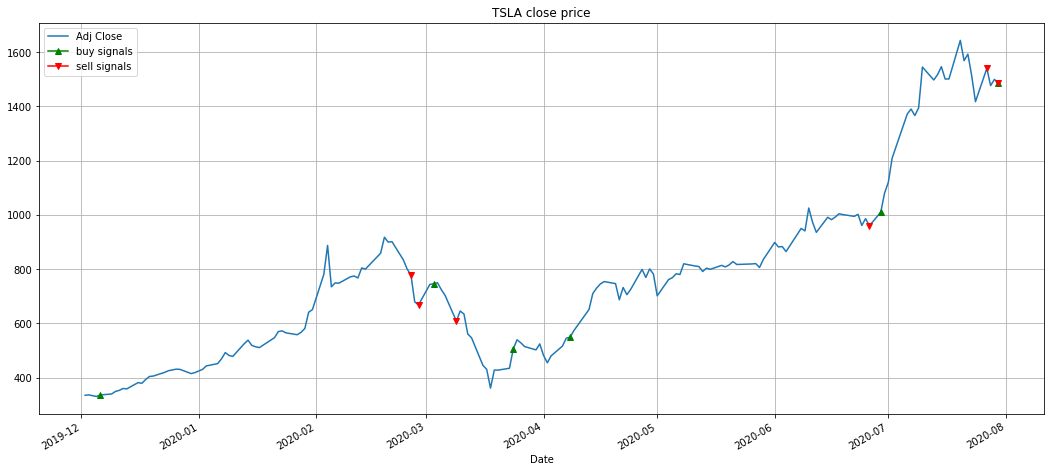

In [72]:

def apply_rsi(close,buy_sell_signal):

    prev_rsi = None
    curr_rsi = None

    data['buy signals'] = close.copy()
    data['sell signals'] = close.copy()

    buy_sig = data['buy signals']
    sell_sig = data['sell signals']
    
    for i in range(0, len(buy_sell_signal)):

        curr_rsi = buy_sell_signal[i]
        if i == 0:
            buy_sig[i] = np.nan
            sell_sig[i] = np.nan
            prev_rsi = curr_rsi
            continue

        # Entering oversold zone
        if prev_rsi != 0 and curr_rsi == 0:
            print("Entering oversold zone at " + str(i))
            sell_sig[i] = close[i]
            buy_sig[i] = np.nan

        # Exiting oversold zone
        elif prev_rsi == 0 and curr_rsi != 0:
            print("Exiting oversold zone at " + str(i))
            buy_sig[i] = close[i]
            sell_sig[i] = np.nan

        # Entering overbought zone
        elif prev_rsi != 100 and curr_rsi == 100:
            print("Entering overbought zone at " + str(i))
            buy_sig[i] = close[i]
            sell_sig[i] = np.nan

        # Exiting overbought zone
        elif prev_rsi == 100 and curr_rsi != 100:
            print("Exiting overbought zone at " + str(i))
            sell_sig[i] = close[i]
            buy_sig[i] = np.nan

        # None of the above
        else:
            buy_sig[i] = np.nan
            sell_sig[i] = np.nan

        prev_rsi = curr_rsi

    return buy_sig, sell_sig

buy, sell = apply_rsi(close,buy_sell_signal)

close.plot(title=stock + " close price", figsize=(18,8))
buy.plot(marker = '^', color='green')
sell.plot(marker = 'v', color='red')
plt.legend()
plt.grid()
plt.show()
